# Survival models

This notebook serves as a pre-prepared pipeline for survival modelling of recurrent events. It owes a debt of gratitude to this blog, due credit goes to the author there: 

https://www.leynu.com/part-i-analysis-of-recurrent-events/

This concerns two hypothetical individuals, who experience events of particular types during times in particular locations. Their exposure time in either location is calculated as one day before and after their first and last event in that particular location. 

Therefore, one may take one of two approaches to recurrent event survival analysis: modelling the time-gap between events, or modelling the time since that person started their exposure in that particular location. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import random
import math

import statsmodels.duration.hazard_regression as sm

This sets **parameters** for the data generation (and later visualisations).

In [2]:
# Number of events to generate
num_ev = 1000
# Maximum number of events to stratify by
max_ev = 10
# Number of days before and after first event at which to start/end exposure:
exposure_end = 1
# Start and end date
start = datetime.strptime('2017-01-01', "%Y-%M-%d")
end = datetime.strptime('2019-01-01', "%Y-%M-%d")
# Types of event
types = ['one', 'two', 'three']
old_types = ["old_" + s for s in types]
# Prediction columns to include
pred_cols = ['pers_id', 'year', 'prev_type', 'num_ev'] + old_types + ['time1', 'time2', 'status']

# Create data

In [3]:
# Random data
dates = [random.random() * (end - start) + start for _ in range(num_ev)]
pers = ['id1', 'id2']
events = pd.DataFrame({'time':dates, 
                       'pers_id':random.choices(pers, k = num_ev), 
                       'type':random.choices(types, k = num_ev)})
events = events.sort_values(by=['pers_id', 'time']).reset_index(drop = True)

events['ev_id'] = range(1, num_ev+1)

In [4]:
# Calculate characteristics of previous events within each person
events['prev_event'] = events.groupby('pers_id').time.shift(1)
events['prev_type'] = events.groupby('pers_id').type.shift(1)
events['next_event'] = events.groupby('pers_id').time.shift(-1)

In [5]:
# Add in locations such that they do not overlap 
# (which would mess with end-of-exposure calculations)
locs = ['loc1', 'loc2']
num_id1 = events.groupby('pers_id').count()['time'][0]
num_id1_1 = int(math.floor(num_id1 / 2)) * [locs[0]]
num_id1_2 = int(math.ceil(num_id1 / 2)) * [locs[1]]
num_id2 = events.groupby('pers_id').count()['time'][1]
num_id2_1 = int(math.floor(num_id2 / 2)) * [locs[0]]
num_id2_2 = int(math.ceil(num_id2 / 2)) * [locs[1]]

events['loc'] = num_id1_1 + num_id1_2 + num_id2_1 + num_id2_2

In [6]:
events.head()

,time,pers_id,type,ev_id,prev_event,prev_type,next_event,loc
0,2017-01-03 08:56:14.057754,id1,one,1,NaT,NaN,2017-01-04 00:00:36.038257,loc1
1,2017-01-04 00:00:36.038257,id1,two,2,2017-01-03 08:56:14.057754,one,2017-01-04 17:06:11.291315,loc1
2,2017-01-04 17:06:11.291315,id1,three,3,2017-01-04 00:00:36.038257,two,2017-01-06 11:27:00.490106,loc1
3,2017-01-06 11:27:00.490106,id1,three,4,2017-01-04 17:06:11.291315,three,2017-01-09 22:23:29.713129,loc1
4,2017-01-09 22:23:29.713129,id1,three,5,2017-01-06 11:27:00.490106,three,2017-01-11 08:36:19.375903,loc1


### Calculated fields

In [7]:
# Running total by event type
timed_totals = events.copy().sort_values(['pers_id', 'time'])
timed_totals['prev_count'] = timed_totals.groupby(['pers_id', 'type'])['type'].cumcount()
timed_totals = timed_totals.pivot_table(index = ['ev_id', 'time', 'pers_id'], 
                                        columns='type', values='prev_count')
timed_totals = timed_totals.reset_index().sort_values(['pers_id', 'time'])
timed_totals = timed_totals.groupby('pers_id').fillna(method = 'backfill')
timed_totals.head()

type,ev_id,one,three,time,two
0,1,0.0,0.0,2017-01-03 08:56:14.057754,0.0
1,2,1.0,0.0,2017-01-04 00:00:36.038257,0.0
2,3,1.0,0.0,2017-01-04 17:06:11.291315,1.0
3,4,1.0,1.0,2017-01-06 11:27:00.490106,1.0
4,5,1.0,2.0,2017-01-09 22:23:29.713129,1.0


In [8]:
# Rename columns
timed_totals.columns = ["old_" + s for s in timed_totals.columns.values]
timed_totals.rename(columns={'old_ev_id':'ev_id', 
                             'old_time':'time', 
                             'old_pers_id':'pers_id'}, inplace=True)

In [9]:
# Merge running counts back onto original list of incidents
events_tot = pd.merge(events, timed_totals, how = 'left', 
                      on = ['ev_id'])
# Grouped forward fill remaining NA's
types_tot = events_tot.groupby("pers_id")[old_types].transform(lambda x: x.fillna(x.max())).fillna(0)
events_all = pd.concat([events, types_tot], axis = 1, ignore_index = True)
events_all.columns = np.concatenate((events.columns.values, old_types), axis = None)

In [10]:
events_all.head()

,time,pers_id,type,ev_id,prev_event,prev_type,next_event,loc,old_one,old_two,old_three
0,2017-01-03 08:56:14.057754,id1,one,1,NaT,NaN,2017-01-04 00:00:36.038257,loc1,0.0,0.0,0.0
1,2017-01-04 00:00:36.038257,id1,two,2,2017-01-03 08:56:14.057754,one,2017-01-04 17:06:11.291315,loc1,1.0,0.0,0.0
2,2017-01-04 17:06:11.291315,id1,three,3,2017-01-04 00:00:36.038257,two,2017-01-06 11:27:00.490106,loc1,1.0,1.0,0.0
3,2017-01-06 11:27:00.490106,id1,three,4,2017-01-04 17:06:11.291315,three,2017-01-09 22:23:29.713129,loc1,1.0,1.0,1.0
4,2017-01-09 22:23:29.713129,id1,three,5,2017-01-06 11:27:00.490106,three,2017-01-11 08:36:19.375903,loc1,1.0,1.0,2.0


### Start and end of location exposure

In [11]:
first_last = events_all.copy().groupby(['pers_id', 'loc'])[['time']].agg(['min', 'max']).reset_index()
first_last.columns = ['pers_id', 'loc', 'first', 'last']

In [12]:
first_last['st'] = first_last['first'] - timedelta(days=exposure_end)
first_last['e'] = first_last['last'] + timedelta(days=exposure_end)

In [13]:
events_st = pd.merge(events_all, first_last, how = 'left', on = ['pers_id', 'loc'])

In [14]:
events_st['start'] = np.where(np.isnat(events_st['prev_event']), events_st['st'], events_st['prev_event'])
events_st['end'] = np.where(np.isnat(events_st['next_event']), events_st['e'], events_st['next_event'])
events_st = events_st.drop_duplicates().sort_values(['pers_id', 'time']).reset_index(drop = True)

In [15]:
# Number of days since beginning of this particular spell
events_st['since_prev'] = (events_st['time'] - events_st['start']).dt.days
# Number of days since start of the spell
events_st['ev_since_start'] = (events_st['time'] - events_st['st']).dt.days
# Number of days since start of spell at the time this one starts
events_st['st_since_start'] = events_st.groupby(['pers_id', 'st', 'e'])['ev_since_start'].shift(1).fillna(0)
# Number of days until the next incident
events_st['to_next'] = (events_st['e'] - events_st['time']).dt.days
events_st['to_next'] = (np.where(np.isnan(events_st['to_next']), 
                                 (events_st['end'] - events_st['start']).dt.days, 
                                 events_st['to_next']))

In [16]:
# Count number of incidents so far, up to the maximum number set as parameter above
events_st['num_ev'] = (events_st.groupby(['pers_id']).cumcount()+1)
events_st['num_ev'] = np.where(events_st['num_ev'] > max_ev, max_ev, events_st['num_ev'])
# In theory, there may be people with spells without any incidents: this line handles those
events_st['num_ev'] = np.where(np.isnat(events_st['time']), 0, events_st['num_ev'])
# Year/month of the incident (to adjust for time trends)
events_st['year'] = events_st.time.dt.year
events_st['month'] = events_st.time.dt.month
events_st['year'] = events_st['year'].fillna(events_st['year'].max())

In [17]:
events_st.head()

,time,pers_id,type,ev_id,prev_event,prev_type,next_event,loc,old_one,old_two,...,e,start,end,since_prev,ev_since_start,st_since_start,to_next,num_ev,year,month
0,2017-01-03 08:56:14.057754,id1,one,1,NaT,NaN,2017-01-04 00:00:36.038257,loc1,0.0,0.0,...,2018-02-04 08:16:12.103324,2017-01-02 08:56:14.057754,2017-01-04 00:00:36.038257,1,1,0.0,396,1,2017,1
1,2017-01-04 00:00:36.038257,id1,two,2,2017-01-03 08:56:14.057754,one,2017-01-04 17:06:11.291315,loc1,1.0,0.0,...,2018-02-04 08:16:12.103324,2017-01-03 08:56:14.057754,2017-01-04 17:06:11.291315,0,1,1.0,396,2,2017,1
2,2017-01-04 17:06:11.291315,id1,three,3,2017-01-04 00:00:36.038257,two,2017-01-06 11:27:00.490106,loc1,1.0,1.0,...,2018-02-04 08:16:12.103324,2017-01-04 00:00:36.038257,2017-01-06 11:27:00.490106,0,2,1.0,395,3,2017,1
3,2017-01-06 11:27:00.490106,id1,three,4,2017-01-04 17:06:11.291315,three,2017-01-09 22:23:29.713129,loc1,1.0,1.0,...,2018-02-04 08:16:12.103324,2017-01-04 17:06:11.291315,2017-01-09 22:23:29.713129,1,4,2.0,393,4,2017,1
4,2017-01-09 22:23:29.713129,id1,three,5,2017-01-06 11:27:00.490106,three,2017-01-11 08:36:19.375903,loc1,1.0,1.0,...,2018-02-04 08:16:12.103324,2017-01-06 11:27:00.490106,2017-01-11 08:36:19.375903,3,7,4.0,390,5,2017,1


# Survival model approach

## Model B: model the gap between events

In [18]:
surv_B = events_st.copy()

In [19]:
# Each spell starts at 0: we're interested in the gap between events
surv_B['time1'] = 0
# Prepare the rows ending in an event
surv_B['time2'] = surv_B['since_prev']
# These rows end in an event
surv_B['status'] = 1

In [20]:
# Prepare the rows ending in leaving a location
last_evs = surv_B.sort_values('time', ascending=False).drop_duplicates(['pers_id', 'st', 'e'])
last_evs['time2'] = last_evs['to_next']
# These rows end in being censored (leaving this location)
last_evs['status'] = 0

In [21]:
# Paste the rows together
surv_B_all = surv_B.append(last_evs, ignore_index=True).sort_values(['pers_id', 'time']).reset_index(drop = True)
surv_B_all.head()

,time,pers_id,type,ev_id,prev_event,prev_type,next_event,loc,old_one,old_two,...,since_prev,ev_since_start,st_since_start,to_next,num_ev,year,month,time1,time2,status
0,2017-01-03 08:56:14.057754,id1,one,1,NaT,NaN,2017-01-04 00:00:36.038257,loc1,0.0,0.0,...,1,1,0.0,396,1,2017,1,0,1,1
1,2017-01-04 00:00:36.038257,id1,two,2,2017-01-03 08:56:14.057754,one,2017-01-04 17:06:11.291315,loc1,1.0,0.0,...,0,1,1.0,396,2,2017,1,0,0,1
2,2017-01-04 17:06:11.291315,id1,three,3,2017-01-04 00:00:36.038257,two,2017-01-06 11:27:00.490106,loc1,1.0,1.0,...,0,2,1.0,395,3,2017,1,0,0,1
3,2017-01-06 11:27:00.490106,id1,three,4,2017-01-04 17:06:11.291315,three,2017-01-09 22:23:29.713129,loc1,1.0,1.0,...,1,4,2.0,393,4,2017,1,0,1,1
4,2017-01-09 22:23:29.713129,id1,three,5,2017-01-06 11:27:00.490106,three,2017-01-11 08:36:19.375903,loc1,1.0,1.0,...,3,7,4.0,390,5,2017,1,0,3,1


In [22]:
# Select columns of interest
surv_B_init = surv_B_all.copy()[pred_cols]

### Modelling - stratify by no. of previous incidents

In [23]:
var_to_strat = 'num_ev'
all_preds = surv_B_init.columns.values
all_preds = all_preds[(all_preds != 'pers_id') & (all_preds != 'status') & 
                      (all_preds != 'time2') & (all_preds != 'time1') &
                      (all_preds != var_to_strat)]

In [24]:
# Fit model stratified by var_to_strat (ie. separate curve for each value)
strat_inc = sm.PHReg.from_formula("time2 ~ "+'+'.join(all_preds), status = "status", 
                                 strata = var_to_strat, data = surv_B_init)
strat_fit = strat_inc.fit()

In [25]:
print(strat_fit.summary())

                             Results: PHReg
Model:                     PH Reg         Num strata:              9    
Dependent variable:        time2          Min stratum size:        2    
Ties:                      Breslow        Max stratum size:        986  
Sample size:               1002           Avg stratum size:        111.3
Num. events:               998                                          
------------------------------------------------------------------------
                    log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
------------------------------------------------------------------------
prev_type[T.three] -0.0092    0.0779 0.9908 -0.1187 0.9055 0.8506 1.1541
prev_type[T.two]   -0.0012    0.0779 0.9988 -0.0148 0.9882 0.8574 1.1636
year                0.0840    0.1418 1.0876  0.5922 0.5537 0.8237 1.4359
old_one             0.0038    0.0087 1.0038  0.4383 0.6611 0.9869 1.0210
old_two            -0.0046    0.0077 0.9954 -0.5979 0.5499 0.9805 1.0105
old_thr

In [26]:
# Save predictions
cumhaz_strat = strat_fit.predict(pred_type='cumhaz').predicted_values
surv_strat = strat_fit.predict(pred_type='surv').predicted_values
all_strats = surv_B_init[var_to_strat].unique()[0:max_ev - 1]

Text(0,0.5,'Cumulative hazard')

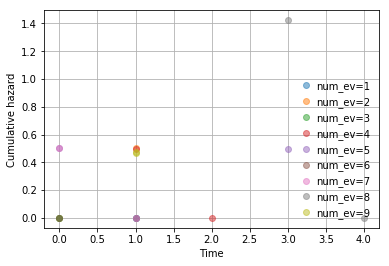

In [27]:
# Visualise cumulative hazard
for i in all_strats:
    surv_data = surv_B_init.index[surv_B_init[var_to_strat] == i].tolist()
    plt.plot(surv_B_init.iloc[surv_data]['time2'], cumhaz_strat[surv_data], 'o', 
             label=str(var_to_strat+'='+str(i)), alpha = 0.5)
leg = plt.legend(numpoints=1, handletextpad=0.0001, loc='lower right')
leg.draw_frame(False)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Cumulative hazard")

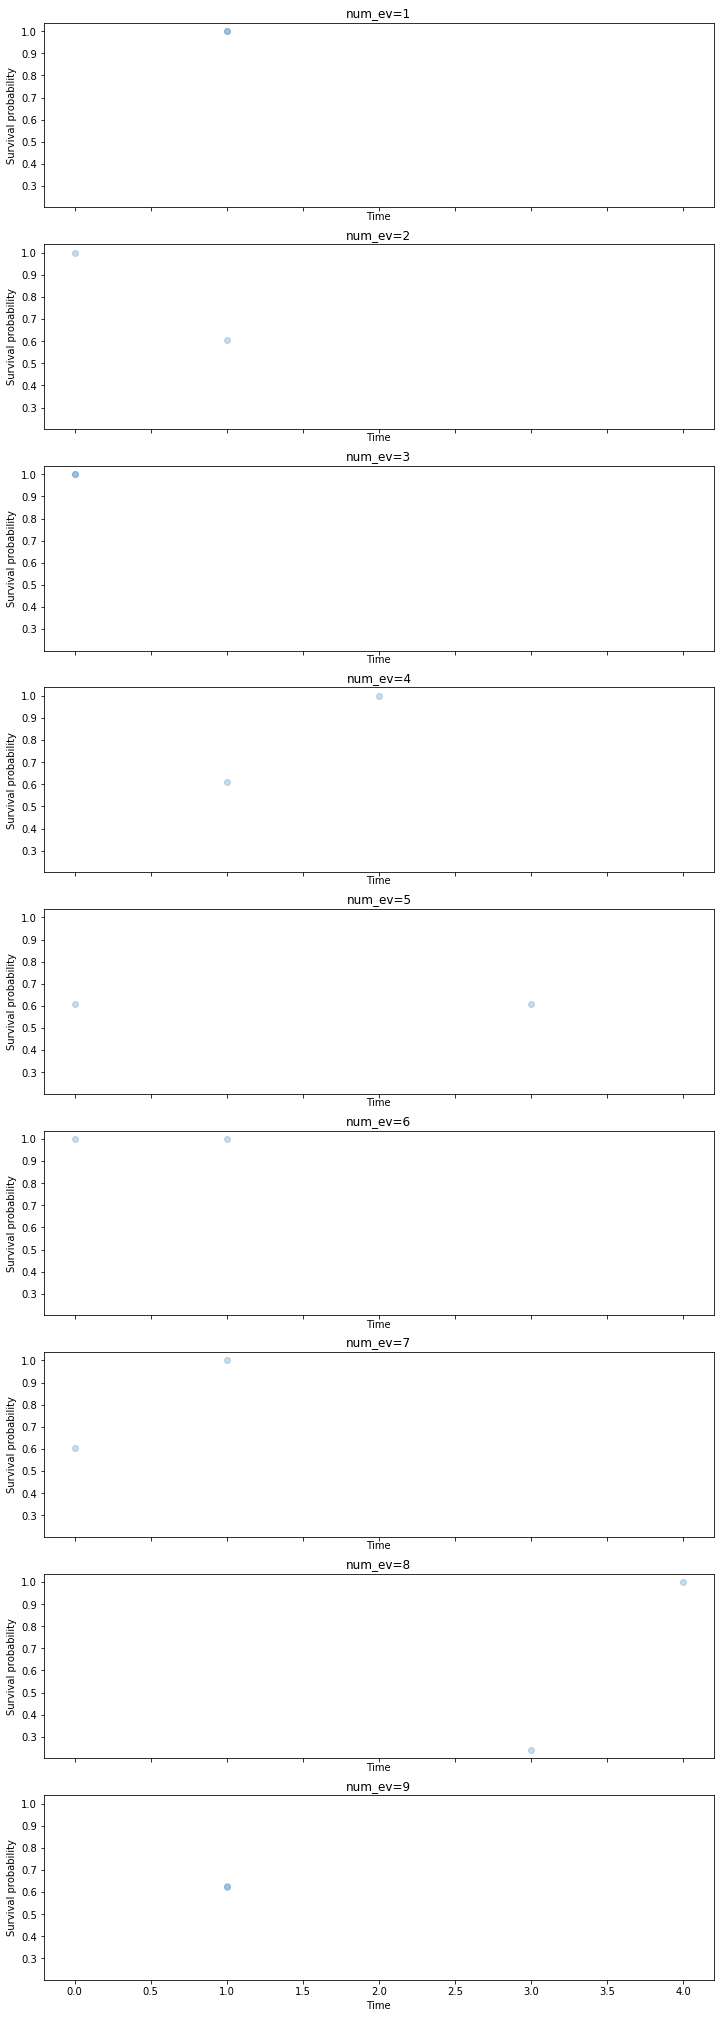

In [28]:
# Visualise survival probability
f, axes = plt.subplots(max_ev - 1, 1, figsize = (12,36), sharex = True, sharey=True)

for idx, i in enumerate(all_strats):
    surv_data = surv_B_init.index[surv_B_init[var_to_strat] == i].tolist()
    axes[idx].plot(surv_B_init.iloc[surv_data]['time2'], surv_strat[surv_data], 'o', alpha = 0.25)
    axes[idx].set_xlabel("Time")
    axes[idx].set_ylabel("Survival probability")
    axes[idx].set_title(str(var_to_strat+'='+str(i)))

## Model A: time since beginning of exposure

In [29]:
surv_A = events_st.copy()
# Time since beginning of exposure (ie. since start of the spell in location)
surv_A['time1'] = surv_A['st_since_start']
surv_A['time2'] = surv_A['ev_since_start']
# These rows end in an incident
surv_A['status'] = 1

In [30]:
last_incs_A = surv_A.sort_values('time', ascending=False).drop_duplicates(['pers_id', 'st', 'e']).drop('time1', axis = 1)
last_incs_A['year'] = last_incs_A.e.dt.year
last_incs_A['month'] = last_incs_A.e.dt.month
last_incs_A['prev_type'] = last_incs_A['type']
last_incs_A['time2'] = (last_incs_A['e'] - last_incs_A['st']).dt.days
time1 = surv_A.groupby(['pers_id', 'st', 'e'])['time2'].max().reset_index()
time1.columns = ['pers_id', 'st', 'e', 'time1']
last_incs_A = pd.merge(last_incs_A, time1, on = ['pers_id', 'st', 'e'], how = 'left')
# Add one for the last incident's severity
last_incs_A['type'] = "old_"+last_incs_A['type']
for typ in last_incs_A['type'].unique():
    last_incs_A[typ] = np.where(last_incs_A['type'] == typ, last_incs_A[typ] + 1, last_incs_A[typ])

# These rows end in being censored (leaving this prison)
last_incs_A['status'] = 0

In [31]:
last_incs_A.head()

,time,pers_id,type,ev_id,prev_event,prev_type,next_event,loc,old_one,old_two,...,since_prev,ev_since_start,st_since_start,to_next,num_ev,year,month,time2,status,time1
0,2018-12-31 16:44:02.411284,id1,old_one,519,2018-12-31 00:40:03.290888,one,NaT,loc2,176.0,155.0,...,0,329,328.0,1,10,2019,1,330,0,329
1,2018-12-31 09:43:57.438201,id2,old_one,1000,2018-12-30 21:35:11.882822,one,NaT,loc2,176.0,165.0,...,0,362,362.0,1,10,2019,1,363,0,362
2,2018-02-03 08:16:12.103324,id1,old_one,259,2018-02-01 06:40:32.672686,one,2018-02-06 06:48:32.385435,loc1,88.0,74.0,...,2,396,394.0,1,10,2018,2,397,0,396
3,2018-01-03 01:29:10.858929,id2,old_one,759,2018-01-01 14:26:14.761829,one,2018-01-03 16:28:10.362065,loc1,92.0,92.0,...,1,364,363.0,1,10,2018,1,365,0,364


In [32]:
# Paste rows ending in incidents and rows ending in leaving the location together
surv_A_all = surv_A.append(last_incs_A, ignore_index=True).reset_index()

/Users/martine/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


In [33]:
surv_A_all.head()

,index,e,end,ev_id,ev_since_start,first,last,loc,month,next_event,...,st,st_since_start,start,status,time,time1,time2,to_next,type,year
0,0,2018-02-04 08:16:12.103324,2017-01-04 00:00:36.038257,1,1,2017-01-03 08:56:14.057754,2018-02-03 08:16:12.103324,loc1,1,2017-01-04 00:00:36.038257,...,2017-01-02 08:56:14.057754,0.0,2017-01-02 08:56:14.057754,1,2017-01-03 08:56:14.057754,0.0,1,396,one,2017
1,1,2018-02-04 08:16:12.103324,2017-01-04 17:06:11.291315,2,1,2017-01-03 08:56:14.057754,2018-02-03 08:16:12.103324,loc1,1,2017-01-04 17:06:11.291315,...,2017-01-02 08:56:14.057754,1.0,2017-01-03 08:56:14.057754,1,2017-01-04 00:00:36.038257,1.0,1,396,two,2017
2,2,2018-02-04 08:16:12.103324,2017-01-06 11:27:00.490106,3,2,2017-01-03 08:56:14.057754,2018-02-03 08:16:12.103324,loc1,1,2017-01-06 11:27:00.490106,...,2017-01-02 08:56:14.057754,1.0,2017-01-04 00:00:36.038257,1,2017-01-04 17:06:11.291315,1.0,2,395,three,2017
3,3,2018-02-04 08:16:12.103324,2017-01-09 22:23:29.713129,4,4,2017-01-03 08:56:14.057754,2018-02-03 08:16:12.103324,loc1,1,2017-01-09 22:23:29.713129,...,2017-01-02 08:56:14.057754,2.0,2017-01-04 17:06:11.291315,1,2017-01-06 11:27:00.490106,2.0,4,393,three,2017
4,4,2018-02-04 08:16:12.103324,2017-01-11 08:36:19.375903,5,7,2017-01-03 08:56:14.057754,2018-02-03 08:16:12.103324,loc1,1,2017-01-11 08:36:19.375903,...,2017-01-02 08:56:14.057754,4.0,2017-01-06 11:27:00.490106,1,2017-01-09 22:23:29.713129,4.0,7,390,three,2017


In [34]:
pred_cols = ['pers_id', 'year', 'prev_type', 'num_ev'] + old_types + ['time1', 'time2', 'status']
surv_A_init = surv_A_all.copy()[pred_cols]

### Modelling - don't stratify by no. of previous incidents

In [35]:
var_to_strat = 'num_ev'
all_preds = surv_A_init.columns.values
all_preds = all_preds[(all_preds != 'id') & (all_preds != 'status') & 
                      (all_preds != 'time2') & (all_preds != 'time1') &
                      (all_preds != var_to_strat)]

In [36]:
strat_inc_A = sm.PHReg.from_formula("time2 ~ "+'+'.join(all_preds) + "+" + var_to_strat, 
                                    status = "status", entry = 'time1', data = surv_A_init)
strat_fit_A = strat_inc_A.fit()

In [37]:
print(strat_fit_A.summary())

                             Results: PHReg
Model:                       PH Reg           Sample size:          1002
Dependent variable:          time2            Num. events:          998 
Ties:                        Breslow                                    
------------------------------------------------------------------------
                    log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
------------------------------------------------------------------------
pers_id[T.id2]     -0.0224    0.1680 0.9779 -0.1331 0.8942 0.7035 1.3593
prev_type[T.three] -0.0402    0.0831 0.9606 -0.4835 0.6288 0.8163 1.1305
prev_type[T.two]   -0.0235    0.0832 0.9768 -0.2825 0.7775 0.8299 1.1497
year               -0.5724    0.6061 0.5641 -0.9444 0.3449 0.1720 1.8506
old_one             0.0087    0.0127 1.0088  0.6903 0.4900 0.9840 1.0342
old_two            -0.0029    0.0096 0.9971 -0.3064 0.7593 0.9784 1.0160
old_three           0.0009    0.0051 1.0009  0.1767 0.8598 0.9910 1.0109
num_ev 

In [38]:
cumhaz_strat_A = strat_fit_A.predict(pred_type='cumhaz').predicted_values
haz_strat_A = strat_fit_A.predict(pred_type = 'hr').predicted_values
surv_strat_A = strat_fit_A.predict(pred_type='surv').predicted_values
all_strats_A = surv_A_init[var_to_strat].unique()[0:max_ev - 1]

/Users/martine/anaconda3/lib/python3.6/site-packages/statsmodels/duration/hazard_regression.py:1137: RuntimeWarning: divide by zero encountered in double_scalars
  h0[i] = len(ix) / xp0
/Users/martine/anaconda3/lib/python3.6/site-packages/statsmodels/duration/hazard_regression.py:1143: RuntimeWarning: invalid value encountered in subtract
  cumhaz = np.cumsum(h0) - h0


Text(0,0.5,'Cumulative hazard')

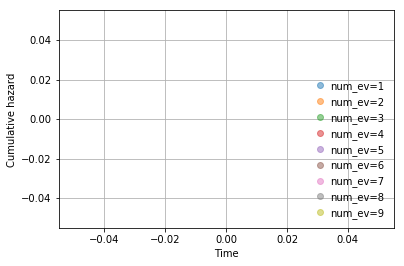

In [39]:
for i in all_strats_A:
    surv_data = surv_A_init.index[surv_A_init[var_to_strat] == i].tolist()
    plt.plot(surv_A_init.iloc[surv_data]['time2'], cumhaz_strat_A[surv_data], 'o', 
             label=str(var_to_strat+'='+str(i)), alpha = 0.5)
leg = plt.legend(numpoints=1, handletextpad=0.0001, loc='lower right')
leg.draw_frame(False)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Cumulative hazard")

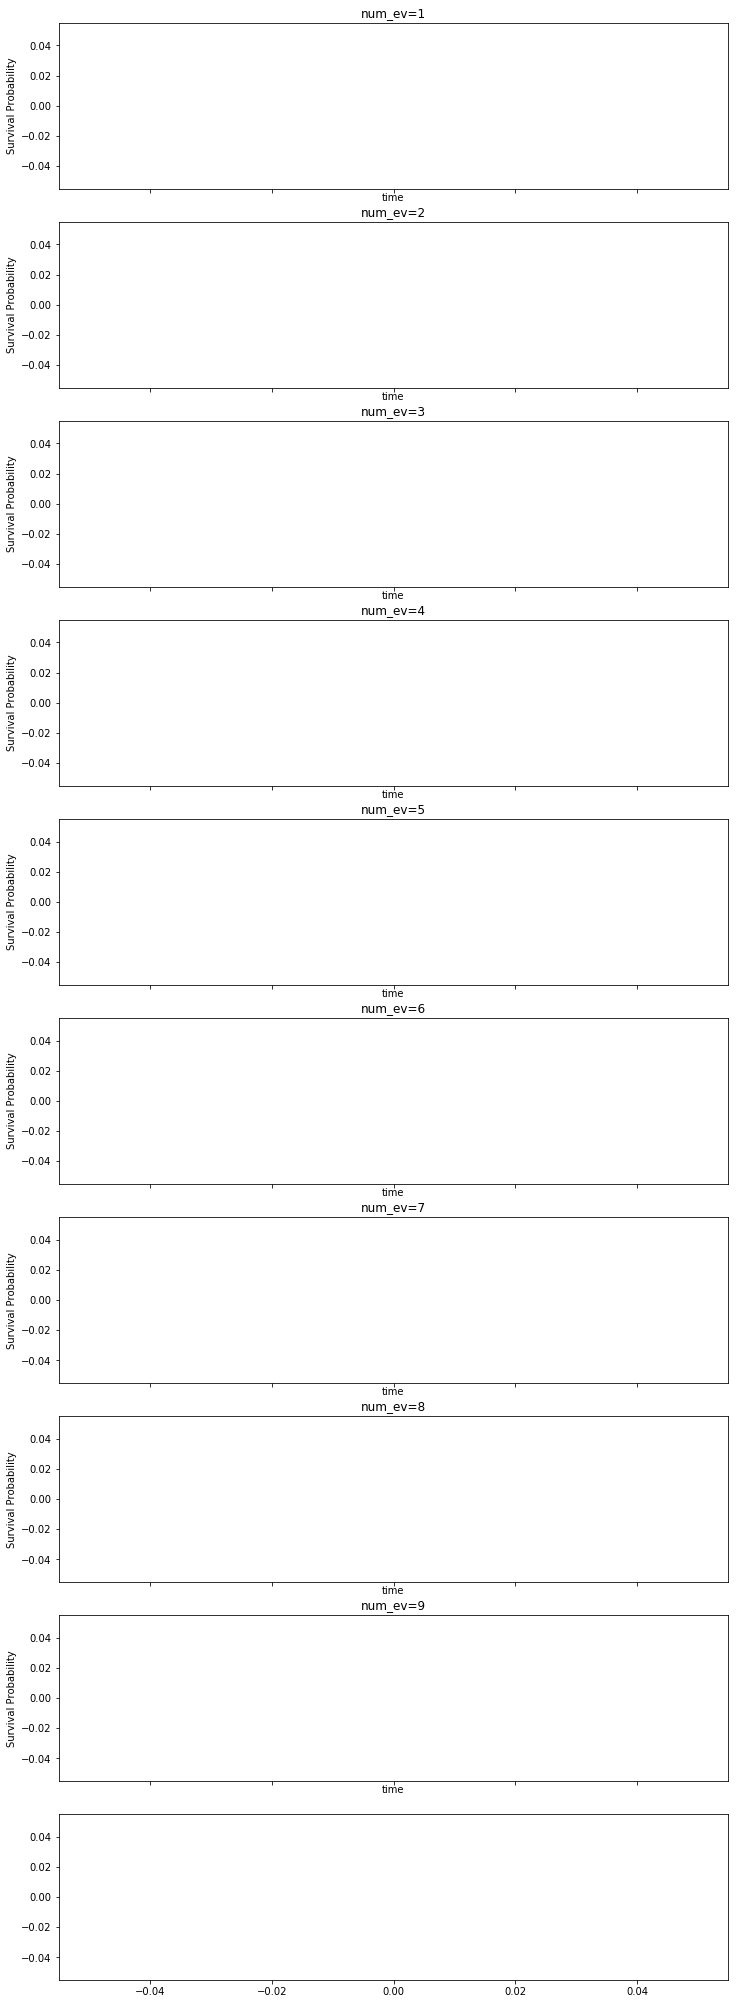

In [40]:
f, axes = plt.subplots(max_ev,1, figsize = (12,36), sharex = True, sharey=True)

for idx, i in enumerate(all_strats_A):
    surv_data = surv_A_init.index[surv_A_init[var_to_strat] == i].tolist()
    axes[idx].plot(surv_A_init.iloc[surv_data]['time2'], surv_strat_A[surv_data], 'o', alpha = 0.25)
    axes[idx].set_xlabel("time")
    axes[idx].set_ylabel("Survival Probability")
    axes[idx].set_title(str(var_to_strat+'='+str(i)))